In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

device = torch.device('cuda:0')
torch.set_default_dtype(torch.float64)


import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline



from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300


In [3]:
n = 100
p = n
d= 3

In [4]:
# regression

X = torch.randn(n,p).to(device)
X/= X.std(0).reshape([1,p])

w0 = torch.from_numpy(np.array([(np.random.normal(5,1,[d])).tolist() +[0]*(p-d)])).t().to(device)

psi = (X@w0)[:,0]

y = psi + torch.rand(n).to(device) * 0.1

In [5]:
idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)])

idx

X= np.eye(n)
for i in range(n):
    for j in range(0,i):
        X[i,j]=np.abs(j-i)+1

X[:,0]=1

# X= np.random.normal(0,1,[n,n])

X = torch.from_numpy(X.astype(np.float64)).to(device)

In [6]:
# idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)])

# w0 = torch.zeros([p]).to(device) 
# w0[idx] = (torch.randn(d)+5).to(device)
# psi = X@w0


# y = psi + torch.rand(n).to(device) * 0.1


In [7]:
w0[idx]

tensor([[0.],
        [0.],
        [0.]], device='cuda:0')

In [8]:
y_np = y.cpu().numpy()

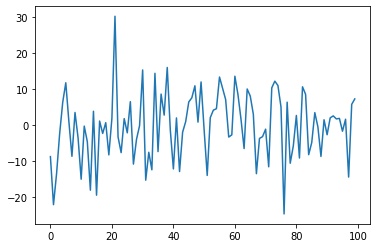

In [9]:
plt.plot(y_np)

In [10]:
# a slightly different TMC

In [11]:
K = 1
latent_dim = 200

In [12]:
n,p = X.shape

X2infNorm= (X**2).sum(0).sqrt().max()

total_param = p*2 + 6

class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask):
        super(RealNVP, self).__init__()

        self.mask = nn.Parameter(mask, requires_grad=False).to(device)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def f(self, z):
        x = z
        log_det_J = z.new_zeros(z.shape[0])
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            log_det_J += s.sum(dim=1)
        return x, log_det_J

    def f_inv(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J


# creating invertible neural nets
mask1 = [0,1]* int(total_param/2)
mask2 = [1- x for x in mask1]

nets = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, total_param), nn.Tanh()).to(device)
nett = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, total_param)).to(device)
masks = torch.from_numpy(np.array([mask1, mask2] * 4)).to(device)

flow_list = [RealNVP(nets, nett, masks) for _ in range(K)]

net_pi = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), 
                               nn.LeakyReLU(), nn.Linear(latent_dim, K), nn.Softmax(dim=1)).to(device)
flow_pi = net_pi()


In [13]:
softplus = torch.nn.functional.softplus

# derivative of sigmoid:
def deri_sigmoid(x,a=1):
    return np.log(a) - a* x  - 2 * (softplus(- a* x))

# derivative of softplus:
def deri_softplus(x):
    return x  - softplus(x)

In [14]:
X2infNorm= (X**2).sum(0).sqrt().max()


In [15]:
X2 = X.T@X
Xy = X.T@y
y2 = y.T@y

In [16]:
eta = torch.eig(X2)[0][0][0] +0.1

In [17]:
etaX2 = torch.eye(p).to(device)*eta - X2

In [18]:
from torch.distributions import gumbel
gum_rng= gumbel.Gumbel(0,1)

def soft_multinomial_log(logPi):
    lam = 0.1
    return torch.softmax((logPi + gum_rng.sample(logPi.shape).to(device))/lam,0)

In [19]:
def loglik(theta, drawTheta = False):

    logJac = 0
    prior = 0

    # parameter z:
    idx = 0
    idx1 = idx + p
    z= theta[:,idx: idx1]

    # latent w
    idx = idx1
    idx1 = idx + p
    w = theta[:,idx: idx1]

    # latent b:
    idx = idx1
    idx1 = idx + 1
    b = torch.sigmoid(theta[:,idx:idx1].flatten())
    logJac+= deri_sigmoid(theta[:,idx:idx1].flatten())

    #  sigma2
    idx = idx1
    idx1 = idx + 1
    sigma2 = softplus(theta[:,idx:idx1].flatten())
    prior += -torch.log(sigma2) #- torch.log(1 + sigma2)   

    # lam:
    idx = idx1
    idx1 = idx + 1
    lam = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    prior += - torch.log(1 + lam**2 / sigma2) - 0.5* torch.log(sigma2)

    # alpha:
    idx = idx1
    idx1 = idx + 1
    alpha = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    prior += - torch.log(1 + alpha**2 / sigma2) - 0.5* torch.log(sigma2)

    part1 = -(n+p)/2 * torch.log(sigma2) + torch.log(lam/alpha) - y2/2/sigma2 - ((etaX2@w.T )*w.T).sum(0)/2/sigma2

    log_choice1 = (z*Xy - eta* (z*z)/2 + (w@etaX2)*z ) / sigma2.reshape([batch_size,1]) - z.abs() * (1/alpha+1/lam).reshape([batch_size,1])

    w1 = torch.log(b/2) - torch.log(lam)
    w2 = torch.log(1-b)

    p1 = log_choice1 + w1.reshape([batch_size,1])
    p2 = torch.repeat_interleave( w2.reshape([batch_size,1]),p,1)

    part2 = torch.logsumexp(torch.stack([p1,p2]), dim=0).sum(1)

    total_posterior = part1 +part2 + (prior+logJac).reshape([batch_size,1])
    
    theta = None
    if(drawTheta):
        c_tensor = soft_multinomial_log(torch.stack([p1,p2]))
        theta = c_tensor[0] * z
    

    return [total_posterior,z, w, b,sigma2, lam, alpha, theta ]


In [20]:
import copy

opt_steps=10000

In [21]:
batch_size=200

In [22]:
def log_reference(z):
    return  0

para_list = list()

for flow in flow_list:
    para_list+= list(flow.parameters())

para_list +=  list(flow_pi.parameters())

best_loss = np.inf
best_model= copy.deepcopy([flow_list , flow_pi])

optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-4)

In [ ]:
# stage 1: optimize the transport
for t in range(opt_steps):

    beta =  torch.rand([batch_size, total_param]).to(device)

    Loglik_list = list()
    z_list = list()

    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(beta)
        
        l, z, w, b,sigma2,lam, alpha,_ = loglik(z_cad)
        
        Loglik_list.append(l +logdetJ + torch.log(flow_pi(z_cad)[:,k]))

    g = - torch.logsumexp(torch.stack(Loglik_list), dim=0) + log_reference(beta)

    loss =  g.mean() 

    softplus =  torch.nn.functional.softplus

    if (t+1)%500==0:
        print(t, loss.item(),  (g.std()/g.mean().abs()).item())
        print("sigma2: ", sigma2.mean().item(), " lam: ",lam.mean().item())

    if loss.item()< best_loss:
        best_model= copy.deepcopy([flow_list , flow_pi])
        best_loss = loss.item()

    if np.isnan(loss.cpu().data.numpy()):    
        flow_list,flow_pi = best_model

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

99 107992.76523741863 0.3371601581081926
sigma2:  52.82376115734116  lam:  3.052040813594717
199 19790.51382960176 0.3036530736735702
sigma2:  82.35728038443521  lam:  5.332098307185624
299 8983.996471652823 0.2736069441782485
sigma2:  101.66869687916488  lam:  3.346633520054802
399 5323.720189789219 0.2220216266305936
sigma2:  115.14678303900847  lam:  2.5900202813931044
499 3754.8415550775544 0.20698549886539763
sigma2:  127.08943713718662  lam:  2.264027937866001
599 2955.6254839933163 0.17087451358534228
sigma2:  138.21928550480544  lam:  1.9843415791347232
699 2449.985473853312 0.1497194049591866
sigma2:  149.6320189496567  lam:  1.6339937440738466
799 2121.910765958292 0.1285105525235088
sigma2:  159.642432030074  lam:  1.3985514648650894


In [ ]:
z_cad, logdetJ = best_model[0][0].f(beta)
l, z, w, b,sigma2,lam, alpha,theta = loglik(z_cad, drawTheta=True)

In [ ]:
plt.plot(theta[0].detach().cpu().numpy())

In [ ]:
plt.plot(w0.detach().cpu().numpy())

In [ ]:
eta.mean(0)

In [ ]:
y_fitted = (X@ eta.mean(0)).detach().cpu().numpy()

plt.plot(y_np)
plt.plot(y_fitted)

In [ ]:
plt.scatter(y_np,y_fitted)

In [ ]:
np.mean((y_np - y_fitted)**2)

In [ ]:
plt.plot(y_np - y_fitted)